## Control Problem with Neural ODE with Energy Functional

In [1]:
%reset -f

In [2]:
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax

import time
from utils import *;

<Figure size 640x480 with 0 Axes>

For some reason, GPU is really slow on this task, so let's use CPU

In [3]:
jax.config.update('jax_platform_name', 'cpu')
print(jax.numpy.ones(3).device()) # should be TFRT_CPU_0

TFRT_CPU_0


We are solving the optimal control problem:
\begin{align}
    u^*(t) = \argmin_{u(t)}{J(u)}
\end{align}
- with $J(u) = \int_0^T (u(t))^2 \, \text{d}t + \frac{1}{2}\left( y(T) - y^* \right)^2$
- subject to the ODE $y'(t) = u(t)$
- terminal states $y(0) = y_0$, and $y(T) \approx y^*$

We want to lean a near-optimal control $\hat u$ by parametrising it via a MLP; or even better, an even simpler linear layer. We will then be able to define the control problem using the Neural ODE formulation.

In [4]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP
    # weight: jax.numpy.ndarray
    # bias: jax.numpy.ndarray

    def __init__(self, data_size, width_size, depth, *args, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size+1,        ## Input is t and y0
            out_size=data_size,         ## Output is yT
            width_size=width_size,
            depth=depth,
            # activation=jax.nn.softplus,
            activation=lambda x:x,      ## No activation at all
            key=key,
        )

        ## Initialise these weights close to OC
        # self.weight = jnp.array([[0., -1.]]) + jax.random.normal(key, (2,))
        # self.bias = jnp.array([1.]) + jax.random.normal(key, (1,))

    def __call__(self, t, y, *args):
        input_vec = jnp.array([t, args[0][0]])  ## args[0] is the y0 PyTree (of size 1) - input_vec must be a 1D array to avoid broadcasting
        return self.mlp(input_vec)
        # return self.weight @ input_vec + self.bias
        # return self.weight @ input_vec


class NeuralODE(eqx.Module):
    u: Func

    def __init__(self, data_size, width_size, depth, *args, key, **kwargs):
        super().__init__(**kwargs)
        self.u = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.u),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1]-ts[0],
            y0=y0,
            args=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [5]:
T = 1.0
N = 200

data_size = 1
width_size = 1
depth = 0
seed = int(time.time())
# seed = 3440
key = jax.random.PRNGKey(seed)

model = NeuralODE(data_size, width_size, depth, key=key)
print("Behold the control term: \n----------------------- \n", model.u)

ts = jnp.linspace(0, T, N)
y0 = jnp.array([1.0])
print("\nTesting the control term: \n----------------------- \n", model.u(ts[0], y0, y0))

Behold the control term: 
----------------------- 
 Func(
  mlp=MLP(
    layers=[
      Linear(
        weight=f32[1,2],
        bias=f32[1],
        in_features=2,
        out_features=1,
        use_bias=True
      )
    ],
    activation=<function <lambda>>,
    final_activation=<function _identity>,
    in_size=2,
    out_size=1,
    width_size=1,
    depth=0
  )
)

Testing the control term: 
----------------------- 
 [0.19391578]


Given the target state $y^*$, we can randomly construct training data.

In [6]:
ystar = 1.0 ## target state

def _get_data(ts, *args, key):
    y0 = jax.random.uniform(key, (1,), minval=-2.0, maxval=4.0)
    yT = jnp.array([ystar])
    return jnp.stack([y0, yT], axis=0)     ## data_size is 1

def get_data(dataset_size, *args, key):
    ts = jnp.linspace(0, T, N)
    key = jax.random.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys

def dataloader(array, batch_size, *args, key):
    dataset_size = array.shape[0]
    indices = jnp.arange(dataset_size)
    perm = jax.random.permutation(key, indices)
    start = 0
    end = batch_size
    while end < dataset_size:
        batch_perm = perm[start:end]
        yield array[batch_perm]
        start = end
        end = start + batch_size

In [7]:
dataset_size = 256
batch_size = 32
data_key, loader_key = jax.random.split(key, 2)

_, ys = get_data(dataset_size, key=data_key)
train_loader = dataloader(ys, batch_size, key=loader_key)

In [86]:
lr = 3e-3
optim = optax.adabelief(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

@eqx.filter_value_and_grad
def grad_loss(model, ti, yi):
    ypred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
    # fatefulness = jnp.mean(0.5 * (yi[:, -1] - ypred[:, -1]) ** 2)
    fatefulness = 0.5 * (yi[:, -1] - ypred[:, -1]) ** 2

    mapped1 = jax.vmap(model.u, in_axes=(0, None, None), out_axes=0)
    mapped2 = jax.vmap(mapped1, in_axes=(1, None, 0), out_axes=0)
    ut = mapped2(jnp.tile(ts[:, jnp.newaxis], yi.shape[0]), ypred, ypred[:, 0])[:,:,0]
    dts = ti[1:] - ti[:-1]
    # energy = jnp.mean(jnp.sum(dts*(ut[:, :-1]**2), axis=1))
    energy = jnp.sum(dts*(ut[:, :-1]**2), axis=1)

    # energy=0
    return jnp.mean(fatefulness + 0.001*energy)

@eqx.filter_jit
def make_step(ti, yi, model, opt_state):
    loss, grads = grad_loss(model, ti, yi)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

Step: 100, Loss: 0.0026610593777149916, Computation time: 0.0019462108612060547
Step: 200, Loss: 0.0034896531142294407, Computation time: 0.0020599365234375
Step: 300, Loss: 0.0027918624691665173, Computation time: 0.002064943313598633
Step: 400, Loss: 0.003554678289219737, Computation time: 0.001653909683227539
Step: 500, Loss: 0.0029903221875429153, Computation time: 0.0016980171203613281
Step: 600, Loss: 0.0025355524849146605, Computation time: 0.0016751289367675781
Step: 700, Loss: 0.0031864324118942022, Computation time: 0.0018579959869384766


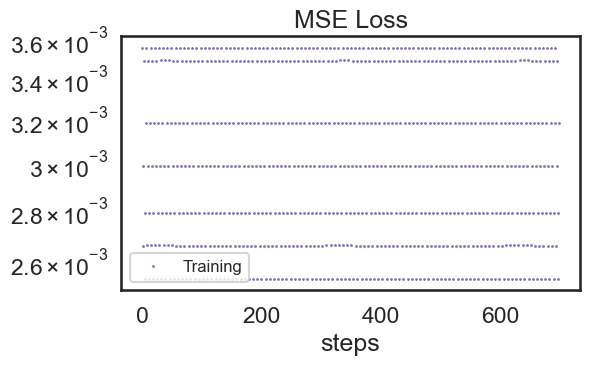

In [92]:
epochs = 100

step = 0
losses = []
for epoch in range(epochs):
    for yi in dataloader(ys, batch_size, key=loader_key):
        start = time.time()
        loss, model, opt_state = make_step(ts, yi, model, opt_state)
        end = time.time()
        step += 1
        losses.append(loss)
        if (step % 100) == 0:
            print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

fig, ax = plt.subplots(1,1,figsize=(6,4))
plot(losses, "m.", label="Training", x_label="steps", title="MSE Loss", markersize=2, ax=ax)
ax.set_yscale('log')

Let's plot the results, and compare them to the known constant optimal control:
\begin{align}
u^*(t) = \frac{y^* - y_0}{T}
\end{align}

In [72]:
## Printing the weights
if hasattr(model.u, 'mlp'):
    print("Learned control weights:", model.u.mlp.layers[0].weight)         ## Should idealy be [0, -1]/T
    print("Learned control bias:", model.u.mlp.layers[0].bias)              ## Should idealy be ystar/T = 1
    print("Check NN strategy:", model.u.mlp.layers[0].weight[0][0] + 2*model.u.mlp.layers[0].bias[0] - 2)
else:
    print("Learned control weights:", model.u.weight)
    print("Learned control bias:", model.u.bias)
    print("Check NN strategy:", model.u.weight[0][0] + 2*model.u.bias[0] - 2)

Learned control weights: [[ 0.11461864 -0.9979998 ]]
Learned control bias: [0.9406812]
Check NN strategy: -0.004018903


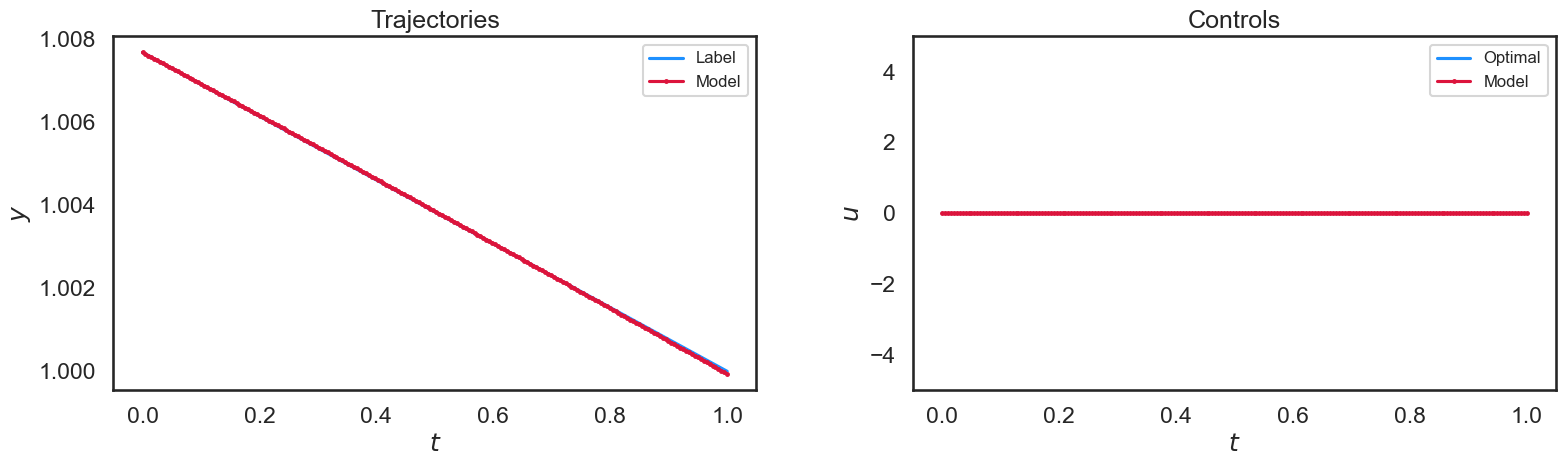

In [98]:
test_gen_key = jax.random.PRNGKey(int(time.time()))

ytrue = _get_data(ts, key=test_gen_key)
ypred = model(ts, ytrue[0])[:]
utrue = jnp.ones_like(ytrue) * (ystar-ytrue[0])/T
upred = jax.vmap(model.u, in_axes=(0, None, None))(ts, ypred, ypred[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8*2, 5))
tplot = [ts[0], ts[-1]]
ax1 = plot(tplot, ytrue, c="dodgerblue", label="Label", title="Trajectories", x_label=r"$t$", y_label=r"$y$", ax=ax1)
ax1 = plot(ts, ypred, ".-", c="crimson", label="Model", markersize=5, ax=ax1)

ax2 = plot(tplot, utrue, c="dodgerblue", label="Optimal", title="Controls", x_label=r"$t$", y_label=r"$u$", ax=ax2)
ax2 = plot(ts, upred, ".-", c="crimson", label="Model", markersize=5, ax=ax2)
ax2.set_ylim(-5, 5);

## Findings
- The rectangle method for integrating $u$ works fine !
- The contribution of the energy functional (corresponding to the Lagrange multiplier) had to be tuned: $\mu = 0.005$
- We could use cross validation to learn that optimal multiplier
- We could use another neuron to learn that optimal multiplier too

## Next steps
- Include middle position as extra constraint
- Use SINDy to recover the governing equation for the controls
- Uncertainty quantify the trajectories, especially when initial state is known
- Generate trajectories based on probability density estimation